库的导入

In [1]:
import os
from pathlib import Path
import numpy as np
import skimage.exposure
import warnings
from io import StringIO
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import skimage.segmentation
import random
from scipy.sparse import coo_array
from scipy.io import loadmat
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 如果你显示中文，改为你系统支持的


In [16]:
def load__with_full_test(data_path: Path, candidate_counts: dict, num_train_per_class=10, seed=42):
    """
    加载 Pavia University 数据集：
    - 从每类中抽取固定数量作为候选样本
    - 从候选中抽取 10 个作为训练样本
    - 所有 ground truth 像素都作为测试样本（包括候选/训练区域）
    """
    random.seed(seed)
    np.random.seed(seed)

    pavia_data = loadmat(data_path / 'PaviaU.mat')['paviaU']
    gt = loadmat(data_path / 'PaviaU_gt.mat')['paviaU_gt']
    h, w, c = pavia_data.shape

    label_dict = {
        1: 'Asphalt road', 2: 'Meadows', 3: 'Gravel',
        4: 'Trees', 5: 'Painted metal sheets', 6: 'Bare Soil',
        7: 'Bitumen', 8: 'Self-Blocking Bricks', 9: 'Shadows',
    }

    train_rows, train_cols, train_data = [], [], []
    candidate_rows, candidate_cols, candidate_data = [], [], []

    for label, cand_count in candidate_counts.items():
        coords = np.argwhere(gt == label)
        if len(coords) < cand_count:
            raise ValueError(f" 类 {label} 样本不足，只有 {len(coords)}，无法抽取 {cand_count} 个候选样本")
        np.random.shuffle(coords)

        candidate_coords = coords[:cand_count]
        train_coords = candidate_coords[:num_train_per_class]

        # 训练样本
        for r, c in train_coords:
            train_rows.append(r)
            train_cols.append(c)
            train_data.append(label)

        # 候选样本（包含训练）
        for r, c in candidate_coords:
            candidate_rows.append(r)
            candidate_cols.append(c)
            candidate_data.append(label)

    # 构建稀疏矩阵
    train_truth = coo_matrix((train_data, (train_rows, train_cols)), shape=(h, w), dtype=int)
    candidate_truth = coo_matrix((candidate_data, (candidate_rows, candidate_cols)), shape=(h, w), dtype=int)

    #  测试集直接包含所有 ground truth
    test_rows, test_cols = np.where(gt > 0)
    test_data = gt[test_rows, test_cols]
    test_truth = coo_matrix((test_data, (test_rows, test_cols)), shape=(h, w), dtype=int)

    info = {
        'n_band': c,
        'width': w,
        'height': h,
        'label_dict': label_dict
    }

    return pavia_data.transpose(2, 0, 1), train_truth, candidate_truth, test_truth, info


def merge_train_test(train_truth, test_truth, shape):
    """
    合并训练集和测试集稀疏矩阵为一个新的训练集矩阵。
    
    参数:
        train_truth: coo_matrix, 原始训练集稀疏矩阵
        test_truth: coo_matrix, 原始测试集稀疏矩阵
        shape: tuple, 数据的形状 (height, width)
        
    返回:
        merged_truth: coo_matrix, 合并后的训练集稀疏矩阵
    """
    # 合并行、列和数据
    merged_rows = np.concatenate([train_truth.row, test_truth.row])
    merged_cols = np.concatenate([train_truth.col, test_truth.col])
    merged_data = np.concatenate([train_truth.data, test_truth.data])
    
    # 创建新的稀疏矩阵
    merged_truth = coo_matrix((merged_data, (merged_rows, merged_cols)), shape=shape)
    return merged_truth

def apply_pca_train_only(hsi_data, train_truth, num_components=40):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    
    参数:
        hsi_data: numpy.ndarray, 高光谱图像数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: int, 保留的主成分数量
        
    返回:
        pca_data: numpy.ndarray, PCA 降维后的数据，形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape  # 高光谱数据的形状
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引
    
    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]
    
    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA
    
    # 转换整个数据集 [C, H, W] -> [H×W, C]
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]
    
    # 恢复为原始图像的形状 [num_components, H, W]
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_

def superpixel_segmentation(hsi_data, num_superpixels=100):
    """
    使用 SLIC 超像素分割对 HSI 进行分割。

    参数:
        hsi_data: numpy.ndarray, 形状为 (C, H, W)
        num_superpixels: 生成的超像素数量
        
    返回:
        labels: 超像素标签矩阵，形状为 (H, W)
    """
    # 先用 PCA 提取第一主成分
    first_pc = PCA(n_components=1).fit_transform(hsi_data.reshape(hsi_data.shape[0], -1).T)
    first_pc = first_pc.reshape(hsi_data.shape[1:])  # 变成 (H, W)

    # 修正错误：复制 3 通道，使其符合 SLIC 需 
    first_pc_rgb = np.stack([first_pc] * 3, axis=-1)  # 变成 (H, W, 3)

    # 正确调用 skimage.segmentation.sli 
    labels = skimage.segmentation.slic(first_pc_rgb, n_segments=num_superpixels, compactness=10, start_label=0, channel_axis=-1)
    
    return labels

def compute_superpixel_feature_map(hsi_data, superpixel_labels):
    """
    对每个超像素提取均值特征（不降维），并生成特征图。
    """
    h, w = superpixel_labels.shape
    c = hsi_data.shape[0]
    superpixel_feature_map = np.zeros((c, h, w), dtype=np.float32)
    superpixel_feature_dict = {}

    unique_labels = np.unique(superpixel_labels)
    for label in unique_labels:
        mask = (superpixel_labels == label)
        if np.sum(mask) == 0:
            continue
        pixels = hsi_data[:, mask].T  # (N, C)
        mean_feat = np.mean(pixels, axis=0)  # (C,)
        superpixel_feature_dict[label] = mean_feat
        for i in range(c):
            superpixel_feature_map[i][mask] = mean_feat[i]

    return superpixel_feature_map, superpixel_feature_dict



def compute_superpixel_pca(hsi_data, superpixel_labels, merged_train_truth, num_components=20):
    """
    仅在训练区域计算每个超像素的局部 PCA，并返回降维后的特征。

    参数:
        hsi_data: numpy.ndarray, 形状为 (C, H, W)
        superpixel_labels: numpy.ndarray, 形状为 (H, W)
        merged_train_truth: coo_matrix, 训练区域掩码
        num_components: int, PCA 维度
        
    返回:
        superpixel_pca_map: numpy.ndarray, 形状为 (num_components, H, W)
        superpixel_pca_dict: dict, 每个超像素的局部PCA结果
    """
    h, w = superpixel_labels.shape
    c = hsi_data.shape[0]
    superpixel_pca_map = np.zeros((num_components, h, w))
    superpixel_pca_dict = {}

    # 获取训练区域坐标
    mask_train = merged_train_truth.toarray() > 0

    unique_labels = np.unique(superpixel_labels)
    for label in unique_labels:
        mask = (superpixel_labels == label)

        # 当前超像素区域内的训练区域
        train_mask = np.logical_and(mask, mask_train)
        if np.sum(train_mask) == 0:
            continue

        pixels = hsi_data[:, train_mask].T  # shape: (num_samples, num_channels)

        # 如果样本数不足，跳过
        if pixels.shape[0] <= num_components:
            continue

        # 执行局部 PCA
        pca = PCA(n_components=num_components)
        reduced_pixels = pca.fit_transform(pixels)
        superpixel_pca_dict[label] = reduced_pixels.T  # shape: (num_components, N)

        # 计算均值写入整块区域
        for i in range(num_components):
            superpixel_pca_map[i, mask] = np.mean(reduced_pixels[:, i])

    return superpixel_pca_map, superpixel_pca_dict



def split_cube(hsi_cube):
    """
    将高光谱立方块沿通道维度均匀切分。
    参数:
        hsi_cube: torch.Tensor, 形状为 [H, W, C]
    返回:
        hsi_cube_a, hsi_cube_b: 两个子立方块
    """
    _, _, c = hsi_cube.shape
    c1 = c // 2  # 每个子块保留一半的通道
    return hsi_cube[:, :, :c1], hsi_cube[:, :, c1:]

def extract_cube(data, x, y, size):
    """
    从高光谱数据中提取局部立方块，并在边界不足时进行填充。
    
    参数:
        data: numpy.ndarray, 形状为 [C, H, W]
        x, y: int, 立方块的中心像素坐标
        size: tuple, 立方块的大小 (s, s)，要求 s 必须是奇数
    
    返回:
        cube: numpy.ndarray, 形状为 [C, s, s]
    """
    assert size[0] % 2 == 1, "立方块大小必须是奇数，以确保中心点对齐。"
    
    c, h, w = data.shape
    half_size = size[0] // 2  # 计算半径

    # 计算提取区域的坐标范围
    x_min, x_max = max(0, x - half_size), min(h, x + half_size + 1)
    y_min, y_max = max(0, y - half_size), min(w, y + half_size + 1)

    # 提取局部数据
    cube = data[:, x_min:x_max, y_min:y_max]

    # 计算需要填充的大小
    pad_x_min, pad_x_max = max(0, half_size - x), max(0, x + half_size + 1 - h)
    pad_y_min, pad_y_max = max(0, half_size - y), max(0, y + half_size + 1 - w)

    # 使用边缘填充，确保输出形状为 (C, size, size)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (pad_x_min, pad_x_max),  # 高度填充
        (pad_y_min, pad_y_max),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="edge")  # 填充值是边界像素，而不是反射
    #cube = np.pad(cube, pad_width, mode="reflect")
    return cube


class FeatureExtractor(nn.Module):
    def __init__(self, input_channels=40):
        """
        特征提取网络。
        参数:
            input_channels: 输入的通道数，例如 20。
        """
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # 第一层卷积
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二层卷积
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 第三层卷积
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # 最大池化层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 卷积 + 批归一化 + 激活 + 池化
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # 展平特征
    

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, output_dim=8):
        """
        特征投影模块。
        参数:
            input_dim: 输入特征的维度，例如 128。
            output_dim: 投影后的维度，例如 8。
        """
        super(ProjectionHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.normalize(self.fc(x), dim=1)  # 投影后的特征归一化


def contrastive_loss(features_a, features_b, temperature=1.0):
    """
    计算对比损失。
    参数:
        features_a, features_b: 投影后的特征，形状为 [batch_size, projection_dim]
        temperature: 温度系数
    返回:
        loss: 对比损失值
    """
    batch_size = features_a.size(0)
    features = torch.cat([features_a, features_b], dim=0)  # 拼接特征
    sim_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)  # 计算相似度
    sim_matrix = sim_matrix / temperature

    # 构造标签
    labels = torch.arange(batch_size, device=features_a.device)
    labels = torch.cat([labels, labels], dim=0)

    # 使用交叉熵损失
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

def extract_precise_superpixel_pca(superpixel_pca_dict, superpixel_labels, x, y):
    """
    获取像素 (x, y) 所属超像素的 SuperPCA 特征。
    
    参数:
        superpixel_pca_dict: 字典，存储每个超像素的 PCA 结果
        superpixel_labels: 超像素标签矩阵
        x, y: 目标像素坐标
        
    返回:
        superpixel_features: numpy.ndarray, 形状为 (20,)
    """
    superpixel_label = superpixel_labels[x, y]  # 获取该像素的超像素标签
    
    # 获取该超像素块的所有 PCA 结果
    superpixel_features = superpixel_pca_dict[superpixel_label]  # 形状为 (20, N)，N 是该超像素块内像素数

    # 取所有像素的平均值，确保返回 20 维的特征向量
    superpixel_features = np.mean(superpixel_features, axis=1)  # 形状变为 (20,)

    return superpixel_features



class S3PCADataset(Dataset):
    def __init__(self, 
                 pca_data, 
                 superpixel_pca_map, 
                 superpixel_pca_dict, 
                 superpixel_labels, 
                 global_pca, 
                 patch_size=11, 
                 num_samples=1000,
                 mode="original"  #  加一个模式选择参数
                ):
        self.pca_data = pca_data
        self.superpixel_pca_map = superpixel_pca_map
        self.superpixel_pca_dict = superpixel_pca_dict
        self.superpixel_labels = superpixel_labels
        self.global_pca = global_pca
        self.patch_size = patch_size
        self.num_samples = num_samples
        self.mode = mode  #  保存模式
        self.h, self.w = pca_data.shape[1], pca_data.shape[2]

        #  构造 valid_coords 列表
        self.valid_coords = [
            (x, y)
            for x in range(patch_size // 2, self.h - patch_size // 2)
            for y in range(patch_size // 2, self.w - patch_size // 2)
            if superpixel_labels[x, y] in superpixel_pca_dict
        ]

    def __len__(self):
        return min(self.num_samples, len(self.valid_coords))

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx % len(self.valid_coords)]

        if self.mode == "raw_only":
            raw_patch = extract_cube(self.pca_data, x, y, (self.patch_size, self.patch_size))
            raw_patch = torch.tensor(raw_patch, dtype=torch.float32)
            half = raw_patch.shape[0] // 2
            cube_a, cube_b = torch.split(raw_patch[:2*half], [half, half], dim=0)
            return cube_a, cube_b

        elif self.mode == "local_global":
            superpixel_feat = self.superpixel_pca_dict[self.superpixel_labels[x, y]]  # shape (103,)
            superpixel_patch = torch.tensor(superpixel_feat[:, None, None], dtype=torch.float32)
            superpixel_patch = superpixel_patch.expand(-1, self.patch_size, self.patch_size)

            global_patch = extract_cube(self.global_pca, x, y, (self.patch_size, self.patch_size)).astype(np.float32)
            global_patch = torch.tensor(global_patch, dtype=torch.float32)

            return superpixel_patch, global_patch


        elif self.mode == "pca_super_rawglobal":
            raw_patch = extract_cube(self.pca_data, x, y, (self.patch_size, self.patch_size))
            raw_patch = torch.tensor(raw_patch, dtype=torch.float32)
            total_channels = raw_patch.shape[0]
            half = total_channels // 2
            raw_a, raw_b = torch.split(raw_patch[:2*half], [half, half], dim=0)

            superpixel_patch = extract_precise_superpixel_pca(self.superpixel_pca_dict, self.superpixel_labels, x, y)
            superpixel_patch = torch.tensor(superpixel_patch[:, None, None], dtype=torch.float32)
            superpixel_patch = superpixel_patch.expand(-1, self.patch_size, self.patch_size)

            global_patch = extract_cube(self.global_pca, x, y, (self.patch_size, self.patch_size))
            global_patch = torch.tensor(global_patch, dtype=torch.float32)

            cube_a = torch.cat([raw_a, superpixel_patch], dim=0)
            cube_b = torch.cat([raw_b, global_patch], dim=0)
            return cube_a, cube_b

        else:  # 默认原始方式
            pca_patch = extract_cube(self.pca_data, x, y, (self.patch_size, self.patch_size))
            pca_patch = torch.tensor(pca_patch, dtype=torch.float32)
            pca_channels = pca_patch.shape[0]
            half_channels = pca_channels // 2
            pca_patch_a, pca_patch_b = torch.split(pca_patch, [half_channels, pca_channels - half_channels], dim=0)

            superpixel_patch = extract_precise_superpixel_pca(self.superpixel_pca_dict, self.superpixel_labels, x, y)
            superpixel_patch = torch.tensor(superpixel_patch[:, None, None], dtype=torch.float32)
            superpixel_patch = superpixel_patch.expand(-1, self.patch_size, self.patch_size)

            global_patch = extract_cube(self.global_pca, x, y, (self.patch_size, self.patch_size))
            global_patch = torch.tensor(global_patch, dtype=torch.float32)

            cube_a = torch.cat([pca_patch_a, superpixel_patch], dim=0)
            cube_b = torch.cat([pca_patch_b, global_patch], dim=0)
            return cube_a, cube_b


def contrastive_loss_ce_hard_negatives(features_a, features_b, temperature=0.1, num_negatives=2):
    """
    Cross-Entropy Contrastive Loss using hardest negative sampling.
    - Each anchor (features_a[i]) uses its positive (features_b[i])
    - Negatives are selected as least similar samples in [features_a; features_b]
    """

    batch_size = features_a.size(0)

    # Normalize
    features_a = F.normalize(features_a, dim=1)
    features_b = F.normalize(features_b, dim=1)

    # Combine: total 2N candidates
    all_features = torch.cat([features_a, features_b], dim=0)  # [2N, D]

    # Cosine sim between anchors and all
    sim_matrix = torch.matmul(features_a, all_features.T) / temperature  # [N, 2N]

    # Mask out own positive (at i + batch_size)
    pos_indices = torch.arange(batch_size, device=features_a.device)
    sim_matrix[torch.arange(batch_size), pos_indices + batch_size] = float('-inf')

    # Select top-k lowest similarity (hard negatives)
    _, neg_indices = torch.topk(sim_matrix, k=num_negatives, dim=1, largest=False)  # [N, k]

    # Construct new logits: [N, 1 + k] → positive + k negatives
    pos_sim = torch.sum(features_a * features_b, dim=1, keepdim=True) / temperature  # [N, 1]
    neg_sims = torch.gather(sim_matrix, 1, neg_indices)  # [N, k]
    logits = torch.cat([pos_sim, neg_sims], dim=1)  # [N, 1+k]

    # Labels: positive is index 0
    labels = torch.zeros(batch_size, dtype=torch.long, device=features_a.device)

    loss = F.cross_entropy(logits, labels)
    return loss

def compute_global_pca(hsi_data, merged_train_truth, num_components=20):
    """
    仅在训练区域计算全局 PCA，并应用到整个 HSI。
    如果训练样本数少于目标维度，则跳过 PCA，直接返回原始数据。
    
    参数:
        hsi_data: numpy.ndarray, 形状为 (B, H, W)
        merged_train_truth: coo_matrix, 标注的训练区域
        num_components: int, PCA 降维维度
        
    返回:
        global_pca_map: numpy.ndarray, 形状为 (num_components, H, W)
    """
    c, h, w = hsi_data.shape
    rows, cols = merged_train_truth.row, merged_train_truth.col
    train_spectra = hsi_data[:, rows, cols].T  # shape: (N, C)
    num_samples = train_spectra.shape[0]

    if num_samples < num_components:
        print(f"样本数 {num_samples} 小于 PCA 维度 {num_components}，跳过 PCA，返回原始数据")
        return hsi_data  # 不降维

    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)

    reshaped_data = hsi_data.reshape(c, -1).T  # shape: (H*W, C)
    reduced_data = pca.transform(reshaped_data)  # shape: (H*W, num_components)
    global_pca_map = reduced_data.T.reshape(num_components, h, w)

    return global_pca_map
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_on_candidate(hsi_data, candidate_truth, num_components=40, use_pca=True):
    """
    在 candidate_truth 区域进行 PCA 或保留原始光谱，返回结果格式统一。
    
    返回：
    - candidate_data: shape [C, H, W]，只在候选区域填值，其余为 0
    - samples: shape [N, C]，候选像素的特征
    - coords: List of (row, col)
    - explained_variance_ratio 或 None
    """
    c, h, w = hsi_data.shape
    rows, cols = candidate_truth.row, candidate_truth.col
    spectra = hsi_data[:, rows, cols].T  # shape: (N, C)
    coords = list(zip(rows, cols))

    if use_pca:
        if num_components > c:
            raise ValueError(f"PCA 维度 {num_components} 不能大于原始通道数 {c}")
        pca = PCA(n_components=num_components)
        reduced = pca.fit_transform(spectra)  # shape: (N, num_components)
        result_c = num_components
        final_data = reduced
        var_ratio = pca.explained_variance_ratio_
    else:
        reduced = spectra
        result_c = c
        final_data = reduced
        var_ratio = None

    # 构建 [C, H, W] 格式，只填候选区域
    candidate_data = np.zeros((result_c, h, w), dtype=np.float32)
    for i, (r, c_) in enumerate(coords):
        candidate_data[:, r, c_] = final_data[i]

    return candidate_data, reduced, coords, var_ratio

def prepare_data_from_loaded(mode, hsi_data, candidate_truth, train_truth, test_truth, info):
    """
    使用你已加载的 pavia、truth 等数据，按模式准备训练用的数据。
    根据模式控制是否对主数据、superpixel 和 global 特征降维。
    """
    merged_truth = merge_train_test(train_truth, test_truth, (info["height"], info["width"]))

    # === 模式配置 ===
    use_pca = mode == "original"
    use_raw = mode == "local_global"
    main_channels = 40 if use_pca else hsi_data.shape[0]
    side_channels = 20 if use_pca else hsi_data.shape[0]

    # === 1. 主数据 ===
    if use_raw:
        main_data = hsi_data  # 不降维
    else:
        main_data, _, _, _ = apply_pca_on_candidate(
            hsi_data, candidate_truth,
            num_components=main_channels,
            use_pca=use_pca
        )

    # === 2. 超像素标签 ===
    superpixel_labels = superpixel_segmentation(hsi_data)

    # === 3. Superpixel 特征 ===
    if use_raw:
        # 不做 PCA，直接用均值光谱
        superpixel_pca_map, superpixel_pca_dict = compute_superpixel_feature_map(
            hsi_data, superpixel_labels
        )
    else:
        superpixel_pca_map, superpixel_pca_dict = compute_superpixel_pca(
            hsi_data, superpixel_labels, candidate_truth, num_components=side_channels
        )

    # === 4. Global 特征 ===
    if use_raw:
        global_pca_map = hsi_data  # 不做 PCA
    else:
        global_pca_map = compute_global_pca(
            hsi_data, candidate_truth, num_components=side_channels
        )

    return main_data, superpixel_pca_map, superpixel_pca_dict, superpixel_labels, global_pca_map

def run_experiment(mode, dataset):
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    input_channels = dataset[0][0].shape[0]  # 获取 cube_a 的通道数
    feature_extractor = FeatureExtractor(input_channels=input_channels).cuda()
    projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(projection_head.parameters()), lr=1e-4)

    os.makedirs('./pth', exist_ok=True)
    num_epochs = 50
    temperature = 1.0
    loss_values = []

    for epoch in range(num_epochs):
        feature_extractor.train()
        projection_head.train()
        epoch_loss = 0

        for cube_a, cube_b in dataloader:
            cube_a, cube_b = cube_a.cuda(), cube_b.cuda()
            features_a = feature_extractor(cube_a)
            features_b = feature_extractor(cube_b)
            proj_a = projection_head(features_a)
            proj_b = projection_head(features_b)

            loss = contrastive_loss_ce_hard_negatives(proj_a, proj_b, temperature=1, num_negatives=10)
            #loss = contrastive_loss(proj_a, proj_b, temperature=1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Mode: {mode} | Loss: {avg_loss:.4f}")

    # 保存模型
    model_path = f'final/model_{mode}.pth'
    print("model:", model_path)
    torch.save({
        'epoch': num_epochs,
        'feature_extractor_state_dict': feature_extractor.state_dict(),
        'projection_head_state_dict': projection_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_values[-1],
    }, model_path)
    print(f"Model saved to: {model_path}")

    # 可选：画损失图
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
    plt.title(f"Loss Curve ({mode})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(f'pth/loss_curve_{mode}.png')
    plt.show()


模式名	                  是否降维	数据组合方式
"original"	             ✅	     20pca + 20super vs 20pca + 20global
"local_global"	         ❌	     super103 vs global103
"pca_super_rawglobal"	 ❌	     raw51 + super103 vs raw51 + global103
"raw_only"	             ❌	     raw51 vs raw51（切半）

Pavia University shape: (103, 610, 340)
Train samples: 90
Candidate samples: 3921
Test samples: 42776
Epoch [1/50] | Mode: raw_only | Loss: 1.2246
Epoch [2/50] | Mode: raw_only | Loss: 0.9725
Epoch [3/50] | Mode: raw_only | Loss: 0.9028
Epoch [4/50] | Mode: raw_only | Loss: 0.8737
Epoch [5/50] | Mode: raw_only | Loss: 0.8577
Epoch [6/50] | Mode: raw_only | Loss: 0.8408
Epoch [7/50] | Mode: raw_only | Loss: 0.8298
Epoch [8/50] | Mode: raw_only | Loss: 0.8238
Epoch [9/50] | Mode: raw_only | Loss: 0.8204
Epoch [10/50] | Mode: raw_only | Loss: 0.8177
Epoch [11/50] | Mode: raw_only | Loss: 0.8161
Epoch [12/50] | Mode: raw_only | Loss: 0.8134
Epoch [13/50] | Mode: raw_only | Loss: 0.8130
Epoch [14/50] | Mode: raw_only | Loss: 0.8109
Epoch [15/50] | Mode: raw_only | Loss: 0.8103
Epoch [16/50] | Mode: raw_only | Loss: 0.8084
Epoch [17/50] | Mode: raw_only | Loss: 0.8083
Epoch [18/50] | Mode: raw_only | Loss: 0.8076
Epoch [19/50] | Mode: raw_only | Loss: 0.8073
Epoch [20/50] | Mode: raw_only | 

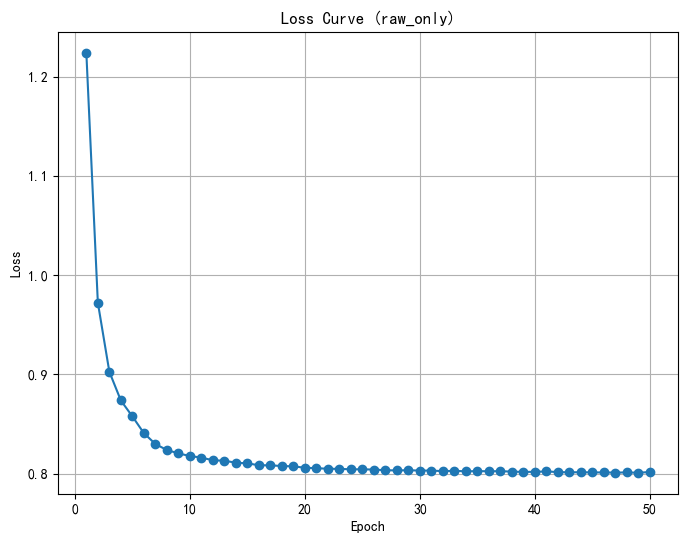

In [ ]:
data_path = Path(r"E:\code\-\对比学习\fx\otherdataset")

candidate_counts = {
    1: 548, 2: 540, 3: 392,
    4: 524, 5: 265, 6: 532,
    7: 375, 8: 514, 9: 231
}

pavia, train_truth, candidate_truth, test_truth, info = load__with_full_test(
    data_path,
    candidate_counts=candidate_counts,
    num_train_per_class=15
)

print(f"Pavia University shape: {pavia.shape}")
print(f"Train samples: {train_truth.count_nonzero()}")         #  90
print(f"Candidate samples: {candidate_truth.count_nonzero()}") #  3921
print(f"Test samples: {test_truth.count_nonzero()}")           #  42776


# 调用 prepare
mode = "raw_only"  # 你想跑的模式
main_data, superpixel_pca_map, superpixel_pca_dict, superpixel_labels, global_pca_map = prepare_data_from_loaded(
    mode, pavia, candidate_truth, train_truth, test_truth, info
)

# 用于 S3PCADataset 构建数据集
dataset = S3PCADataset(
    main_data,
    superpixel_pca_map,
    superpixel_pca_dict,
    superpixel_labels,
    global_pca_map,
    mode=mode
)

run_experiment(mode, dataset)


In [18]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import cohen_kappa_score
import numpy as np

# === 模式选择 ===
mode = "raw_only"  # original, local_global, pca_super_rawglobal, raw_only

# === 输入通道定义（匹配对比训练）===
def get_input_channels_for_classification(mode):
    if mode == "original":
        return 20
    elif mode == "local_global":
        return 103
    elif mode == "pca_super_rawglobal":
        return 51 + 103
    elif mode == "raw_only":
        return 51
    else:
        raise ValueError(f"未知模式: {mode}")
# === 从稀疏矩阵提取 label ===
def extract_labels(truth, label_dict):
    rows, cols, labels = truth.row, truth.col, truth.data
    label_to_index = {label_value: idx for idx, label_value in enumerate(label_dict.keys())}
    mapped_labels = [label_to_index[label] for label in labels if label in label_to_index]
    return [(row, col, label) for row, col, label in zip(rows, cols, mapped_labels)]

# === 分类数据集 ===
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, patch_size=11):
        self.data = data
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y, label = self.labels[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))
        cube = cube.astype(np.float32)

        return torch.tensor(cube), torch.tensor(label, dtype=torch.long)


# === 特征提取器 ===
class FeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)

# === 分类头 ===
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# === 分类训练函数 ===
def train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=50):
    feature_extractor.train()
    classification_head.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda()
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if epoch < 20:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss / len(train_loader):.4f}")

import torch
from sklearn.metrics import cohen_kappa_score

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Per-class Accuracy
    per_class_accuracy = class_correct.float() / class_total.float()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    print("\nPer-class Accuracy:")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"Class {cls}: {acc:.4f}")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"{acc:.4f}")
    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy.cpu().numpy()





from sklearn.decomposition import PCA

def prepare_data_by_mode(mode, hsi_data, train_truth=None, test_truth=None, num_superpixel_components=51):
    """
    根据 mode 返回 main_data:
    - "local_global": 使用原始高光谱数据，不做降维
    - "raw_only": 使用 PCA 全图降维
    - "pca_super_rawglobal": 原始数据 + 局部 PCA（仅用有标签区域拟合）拼接
    """
    print(f"[prepare_data_by_mode] 当前模式: {mode}")
    C_raw, H, W = hsi_data.shape

    if mode == "original":
        print("使用原始高光谱数据，不做 PCA")
        return hsi_data

    elif mode == "raw_only":
        num_components = 51
        reshaped = hsi_data.reshape(C_raw, -1).T  # shape: (H*W, C)
        print(f"对全图做 PCA 降维到 {num_components} 维...")
        pca = PCA(n_components=num_components, svd_solver='auto')
        reduced = pca.fit_transform(reshaped).T  # shape: (num_components, H*W)
        reduced_data = reduced.reshape(num_components, H, W)
        print(f"PCA 完成，降维后形状: {reduced_data.shape}")
        return reduced_data
    elif mode == "local_global":
        return hsi_data
    elif mode == "local_global1":
        if train_truth is None or test_truth is None:
            raise ValueError("必须提供 train_truth 和 test_truth 用于构造局部 PCA 区域")

        # 1. 构建全图上的标签区域（合并 train 和 test）
        merged_truth = merge_train_test(train_truth, test_truth, shape=(H, W))

        # 2. 超像素分割（对整个图做）
        superpixel_labels = superpixel_segmentation(hsi_data)

        # 3. 在 merged truth 区域执行每个超像素的 PCA 拟合，输出整个图的特征图
        superpixel_pca_map, _ = compute_superpixel_pca(
            hsi_data, superpixel_labels, merged_truth,
            num_components=num_superpixel_components
        )

        # 4. 拼接原始数据和 superpixel PCA 特征图
        combined = np.concatenate([hsi_data, superpixel_pca_map], axis=0)
        print(f"[组合特征] 原始: {hsi_data.shape} + SuperPCA: {superpixel_pca_map.shape} → 总: {combined.shape}")
        return combined

    else:
        raise NotImplementedError(f"暂未支持的 mode: {mode}")



In [10]:
mode

'original'

In [24]:
# === STEP 1: 准备分类输入数据 ===
'''
main_data = prepare_data_by_mode(
    mode, pavia
)
'''
main_data = prepare_data_by_mode(
    mode=mode,
    hsi_data=pavia,
    train_truth=train_truth,
    test_truth=test_truth,
    num_superpixel_components=51  # 你可以调这个
)

print(f"\n[调试] 当前模式: {mode}")
print(f"[调试] 输入数据 main_data.shape: {main_data.shape} (channels, height, width)")

train_labels = extract_labels(train_truth, info["label_dict"])
test_labels = extract_labels(test_truth, info["label_dict"])
patch_size = 11  # 可自定义

train_dataset = ClassificationDataset(main_data, train_labels, patch_size=patch_size)
test_dataset = ClassificationDataset(main_data, test_labels, patch_size=patch_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# === STEP 2: 模型准备 ===
# 自动从 main_data 获取输入通道数
actual_input_channels = main_data.shape[0]
expected_input_channels = get_input_channels_for_classification(mode)

print(f"[调试] 实际输入通道数: {actual_input_channels}")
print(f"[调试] 模式期望通道数: {expected_input_channels}")
if actual_input_channels != expected_input_channels:
    print(" 通道数不一致！已使用实际输入通道数进行初始化")

feature_extractor = FeatureExtractor(input_channels=actual_input_channels).cuda()

checkpoint_path = f"final/model_{mode}.pth"
print("模型：",checkpoint_path)
checkpoint = torch.load(checkpoint_path)
pretrained_state = checkpoint['feature_extractor_state_dict']
current_state = feature_extractor.state_dict()

# 只加载 shape 一致的层
filtered_state = {
    k: v for k, v in pretrained_state.items()
    if k in current_state and v.shape == current_state[k].shape
}

print(f"[调试] 可加载层数: {len(filtered_state)} / {len(pretrained_state)}")

# 更新模型参数并加载
current_state.update(filtered_state)
feature_extractor.load_state_dict(current_state)
print(f" 成功加载部分预训练参数（自动适配输入通道）")

# === 后续流程保持不变 ===


[prepare_data_by_mode] 当前模式: raw_only
对全图做 PCA 降维到 51 维...
PCA 完成，降维后形状: (51, 610, 340)

[调试] 当前模式: raw_only
[调试] 输入数据 main_data.shape: (51, 610, 340) (channels, height, width)
[调试] 实际输入通道数: 51
[调试] 模式期望通道数: 51
模型： final/model_raw_only.pth
[调试] 可加载层数: 21 / 21
 成功加载部分预训练参数（自动适配输入通道）


In [25]:
for param in feature_extractor.parameters():
    param.requires_grad = True

classification_head = ClassificationHead(128, num_classes=len(info["label_dict"])).cuda()
optimizer = optim.Adam([
    {"params": feature_extractor.parameters(), "lr": 1e-4},
    {"params": classification_head.parameters(), "lr": 1e-3},
])
criterion = nn.CrossEntropyLoss()

# === STEP 3: 训练 ===
train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=200)

# === STEP 4: 评估 ===
evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes=len(info["label_dict"]))




Epoch 1/200 | Loss: 2.4146
Epoch 2/200 | Loss: 1.9953
Epoch 3/200 | Loss: 1.7216
Epoch 4/200 | Loss: 1.5855
Epoch 5/200 | Loss: 1.4691
Epoch 6/200 | Loss: 1.3209
Epoch 7/200 | Loss: 1.3413
Epoch 8/200 | Loss: 1.2250
Epoch 9/200 | Loss: 1.1484
Epoch 10/200 | Loss: 1.0691
Epoch 11/200 | Loss: 1.0428
Epoch 12/200 | Loss: 0.9356
Epoch 13/200 | Loss: 0.9080
Epoch 14/200 | Loss: 0.8439
Epoch 15/200 | Loss: 0.8150
Epoch 16/200 | Loss: 0.7737
Epoch 17/200 | Loss: 0.7337
Epoch 18/200 | Loss: 0.7185
Epoch 19/200 | Loss: 0.6480
Epoch 20/200 | Loss: 0.6232
Epoch 21/200 | Loss: 0.6020
Epoch 22/200 | Loss: 0.5908
Epoch 23/200 | Loss: 0.6332
Epoch 24/200 | Loss: 0.5465
Epoch 25/200 | Loss: 0.5530
Epoch 26/200 | Loss: 0.5133
Epoch 27/200 | Loss: 0.4852
Epoch 28/200 | Loss: 0.4516
Epoch 29/200 | Loss: 0.4099
Epoch 30/200 | Loss: 0.4367
Epoch 31/200 | Loss: 0.4004
Epoch 32/200 | Loss: 0.3923
Epoch 33/200 | Loss: 0.3569
Epoch 34/200 | Loss: 0.3310
Epoch 35/200 | Loss: 0.3267
Epoch 36/200 | Loss: 0.3646
E

(0.7940901440059847,
 0.848615288734436,
 0.7406423915781228,
 [2,
  2,
  2,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  3,
  5,
  5,
  5,
  5,
  5,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  8,
  3,
  5,
  5,
  5,
  5,
  5,
  6,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2

In [21]:
len(info["label_dict"])

9

local global
Overall Accuracy: 0.7881
Average Accuracy: 0.8242
Kappa Coefficient: 0.7287

Prediction Distribution:
Class 0: 5362 predictions
Class 1: 15654 predictions
Class 2: 3483 predictions
Class 3: 3267 predictions
Class 4: 1353 predictions
Class 5: 7359 predictions
Class 6: 1621 predictions
Class 7: 3698 predictions
Class 8: 979 predictions

Per-class Accuracy:
Class 0: 0.7406
Class 1: 0.7971
Class 2: 0.7423
Class 3: 0.9566
Class 4: 0.9896
Class 5: 0.7578
Class 6: 0.8301
Class 7: 0.6143
Class 8: 0.9894